In [1]:
import numpy as np
import argparse
import numbers
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.transforms.functional import normalize

from matplotlib import pyplot as plt

import models
import criterion
from utils import ext_transforms as et
from utils.nerve import Nerve

args = {
    "param_ckpt" : "/home/dongik/src/cpn-TMP640-result/Oct14-16-19-51/best-param/run_00/fold_00/backbone.pt",
    "dst_pth" : "",
    "data_pth" : "/home/dongik/datasets",
    "num_workers" : 8,
    "modality" : "UN",
    "region" : "peroneal",
    "kfold" : 5,
    "k" : 0,
    "batch_size" : 16,
}
class Denormalize(object):
    def __init__(self, mean, std):
        mean = np.array(mean)
        std = np.array(std)
        self._mean = -mean/std
        self._std = 1/std

    def __call__(self, tensor):
        if isinstance(tensor, np.ndarray):
            return (tensor - self._mean.reshape(-1,1,1)) / self._std.reshape(-1,1,1)
        return normalize(tensor, self._mean, self._std)
denorm = Denormalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

def cmap(N=3, preds=False):
        color_map = np.zeros((N, 3), dtype='uint8')
        color_map[0] = np.array([255, 255, 255])
        color_map[1] = np.array([255, 0, 0]) if preds else np.array([0, 0, 255])
        color_map[2] = np.array([50, 200, 100])
        return color_map
cmp = cmap(N=3, preds=False)

def get_pnt(pnt, crop_size):
    # Height
    if pnt[0] >= crop_size[0]/2 and (640 - pnt[0]) >= crop_size[0]/2:
        lt = (int(pnt[0] - crop_size[0]/2), 0)
        rb = (int(pnt[0] + crop_size[0]/2), 0)
    elif pnt[0] < crop_size[0]/2 and (640 - pnt[0]) >= crop_size[0]/2:
        lt = (0, 0)
        rb = (crop_size[0], 0)
    elif pnt[0] >= crop_size[0]/2 and (640 - pnt[0]) < crop_size[0]/2:
        lt = (640 - crop_size[0], 0)
        rb = (640, 0)
    lt = list(lt)
    rb = list(rb)
    # Width
    if pnt[1] >= crop_size[1]/2 and (640 - pnt[1]) >= crop_size[1]/2:
        lt[1] = int(pnt[1] - crop_size[1]/2)
        rb[1] = int(pnt[1] + crop_size[1]/2)
    elif pnt[1] < crop_size[1]/2 and (640 - pnt[1]) >= crop_size[1]/2:
        lt[1] = 0
        rb[1] = crop_size[1]
    elif pnt[1] >= crop_size[1]/2 and (640 - pnt[1]) < crop_size[1]/2:
        lt[1] = 640 - crop_size[1]
        rb[1] = 640

    return lt, rb

def show(ims, mas, bbox, outputs):
    crop_size = (256, 256)

    for i in range(ims.size()[0]):
   
        print(ims[i].size())
        tar = (denorm(ims[i].numpy()) * 255).transpose(1, 2, 0).astype(np.uint8)
        mtar = cmp[mas[i, ...].numpy()]
        anchor = ((bbox[i].numpy() * 640) + 320).astype(np.int32)
        pred = ((outputs[i].numpy() * 640) + 320).astype(np.int32)
        print(anchor, pred)
        lt, rb = get_pnt(anchor, crop_size)
        mtar[lt[0]:rb[0], lt[1]:lt[1]+3, ...] = [255, 0, 0]
        mtar[lt[0]:rb[0], rb[1]-3:rb[1], :, ...] = [255, 0, 0]
        mtar[lt[0]:lt[0]+3, lt[1]:rb[1], :, ...] = [255, 0, 0]
        mtar[rb[0]-3:rb[0], lt[1]:rb[1], ...] = [255, 0, 0]

        mtar[anchor[0]-3:anchor[0]+3, anchor[1]-30:anchor[1]+30, ...] = [255, 0, 0]
        mtar[anchor[0]-30:anchor[0]+30, anchor[1]-3:anchor[1]+3, ...] = [255, 0, 0]

        lt, rb = get_pnt(pred, crop_size)
        mtar[lt[0]:rb[0], lt[1]:lt[1]+3, ...] = [0, 255, 0]
        mtar[lt[0]:rb[0], rb[1]-3:rb[1], :, ...] = [0, 255, 0]
        mtar[lt[0]:lt[0]+3, lt[1]:rb[1], :, ...] = [0, 255, 0]
        mtar[rb[0]-3:rb[0], lt[1]:rb[1], ...] = [0, 255, 0]

        mtar[pred[0]-3:pred[0]+3, pred[1]-30:pred[1]+30, ...] = [0, 255, 0]
        mtar[pred[0]-30:pred[0]+30, pred[1]-3:pred[1]+3, ...] = [0, 255, 0]

        plt.subplot(1, 2, 1)
        plt.imshow(tar, cmap='gray')
        plt.subplot(1, 2, 2)
        plt.imshow(mtar, cmap='gray')
        plt.show()

def _show(ims, mas, ):

    for i in range(ims.size()[0]):
        tar = (denorm(ims[i].numpy()) * 255).transpose(1, 2, 0).astype(np.uint8)
        mtar = cmp[mas[i, ...].numpy()]
        plt.subplot(1, 2, 1)
        plt.imshow(tar, cmap='gray')
        plt.subplot(1, 2, 2)
        plt.imshow(mtar, cmap='gray')
        plt.show()


def crop(ims, mas, anchor, devices, crop_size=256):
    if isinstance(crop_size, numbers.Number):
        crop_size = (int(crop_size), int(crop_size))
    else:
        crop_size = crop_size
    
    cims = torch.zeros((ims.shape[0], 3, crop_size[0], crop_size[1]), 
                        device=devices, dtype=ims.dtype, )
    cmas = torch.zeros((mas.shape[0], crop_size[0], crop_size[1]), 
                        device=devices, dtype=torch.long,)
    
    anchor = ((anchor * 640) + 320).type(torch.int32)
    
    for i in range(ims.size()[0]):

        lt, rb = get_pnt(anchor[i], crop_size)
        print(lt, rb)
        cims[i, ...] = ims[i, ...][... , lt[0]:rb[0], lt[1]:rb[1]]
        cmas[i, ...] = mas[i, ...][lt[0]:rb[0], lt[1]:rb[1]]
        
    return cims, cmas

def recover(ims, mas, cmas, anchor, devices, crop_size=(256, 256)):
    anchor = ((anchor * 640) + 320).type(torch.int32)
    result = torch.zeros((ims.shape[0], 3, crop_size[0], crop_size[1]), 
                        device=devices, dtype=ims.dtype, )
    for i in range(ims.size()[0]):
        lt, rb = get_pnt(anchor[i], crop_size=(256, 256))
        result[i, ...][lt[0]:rb[0], lt[1]:rb[1]] = cmas[i, ...]
    
    return result
    

/home/dongik/.conda/envs/CPNKDv5/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset - v5/0/peroneal
	Test	101
Best epoch: 2


  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([3, 640, 640])
[209 291] [194 328]


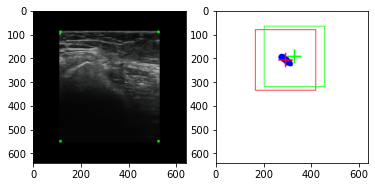

torch.Size([3, 640, 640])
[205 245] [175 319]


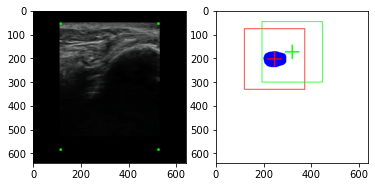

torch.Size([3, 640, 640])
[132 293] [178 309]


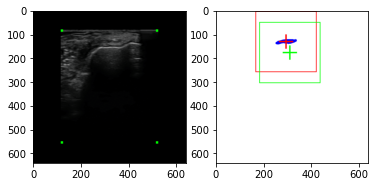

torch.Size([3, 640, 640])
[130 321] [181 332]


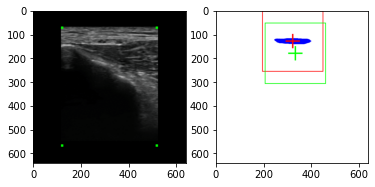

torch.Size([3, 640, 640])
[286 356] [182 307]


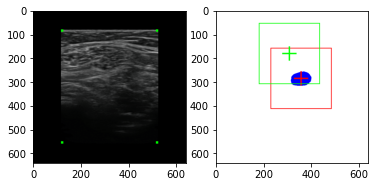

torch.Size([3, 640, 640])
[155 321] [191 311]


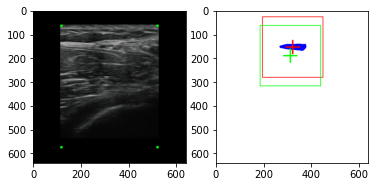

torch.Size([3, 640, 640])
[203 287] [193 338]


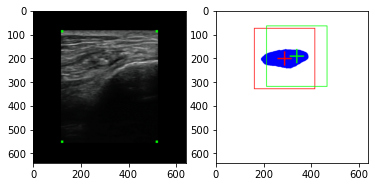

torch.Size([3, 640, 640])
[231 295] [165 303]


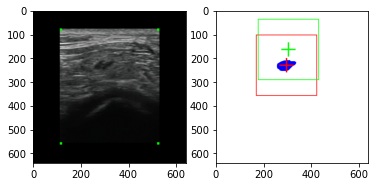

torch.Size([3, 640, 640])
[224 310] [200 323]


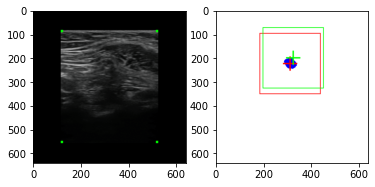

torch.Size([3, 640, 640])
[242 356] [196 319]


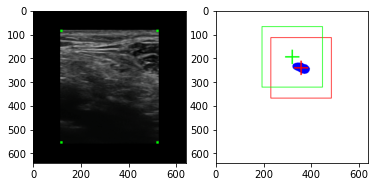

torch.Size([3, 640, 640])
[178 286] [183 321]


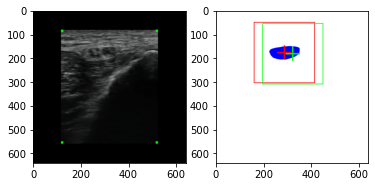

torch.Size([3, 640, 640])
[142 479] [193 332]


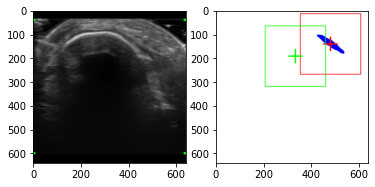

torch.Size([3, 640, 640])
[174 353] [176 313]


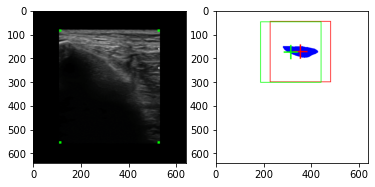

torch.Size([3, 640, 640])
[235 289] [189 338]


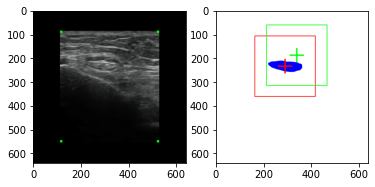

torch.Size([3, 640, 640])
[198 290] [177 309]


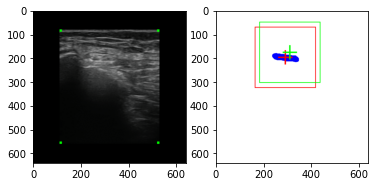

torch.Size([3, 640, 640])
[223 318] [188 316]


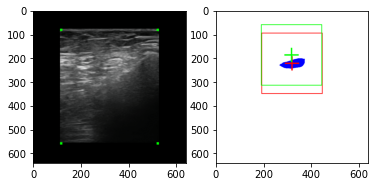

[66, 200] [322, 456]
[47, 191] [303, 447]
[50, 181] [306, 437]
[53, 204] [309, 460]
[54, 179] [310, 435]
[63, 183] [319, 439]
[65, 210] [321, 466]
[37, 175] [293, 431]
[72, 195] [328, 451]
[68, 191] [324, 447]
[55, 193] [311, 449]
[65, 204] [321, 460]
[48, 185] [304, 441]
[61, 210] [317, 466]
[49, 181] [305, 437]
[60, 188] [316, 444]
torch.Size([16, 3, 256, 256]) torch.Size([16, 256, 256])


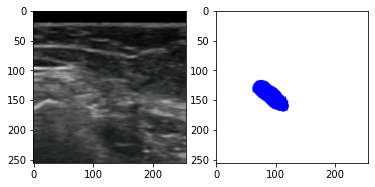

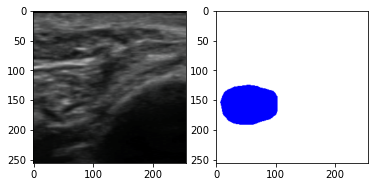

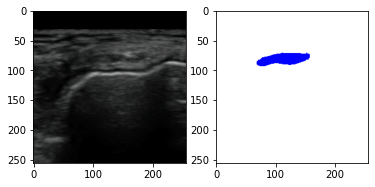

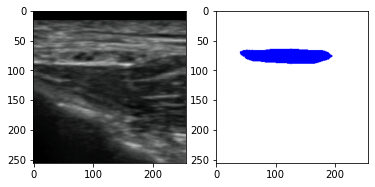

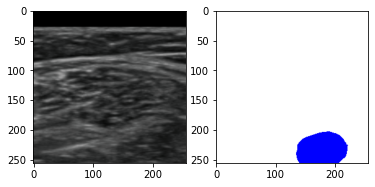

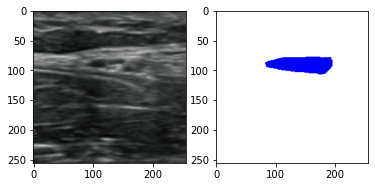

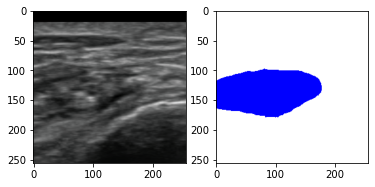

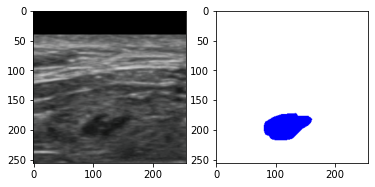

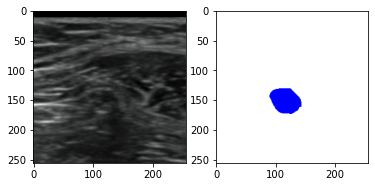

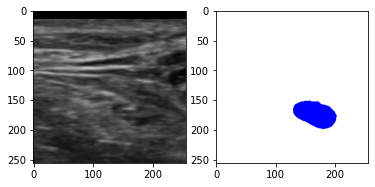

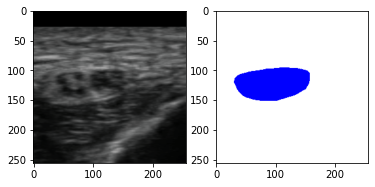

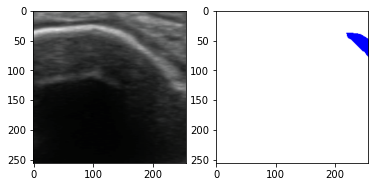

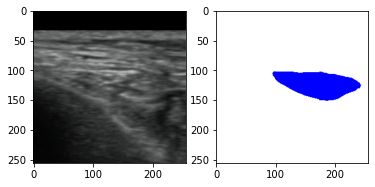

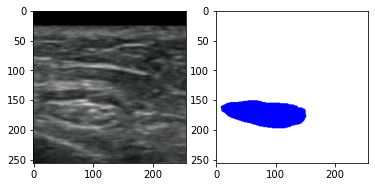

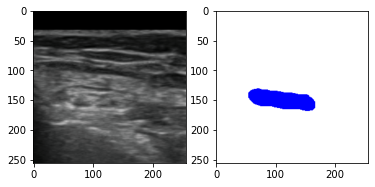

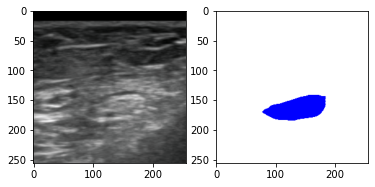

  0%|          | 0/6 [00:08<?, ?it/s]


running loss : 0.088344 / 6
Epoch loss : 0.000875


In [3]:
devices = torch.device('cuda:4' if torch.cuda.is_available() else 'cpu')

norm = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
transform = et.ExtCompose([
    et.ExtToTensor(),
    et.ExtNormalize(mean=norm[0], std=norm[1]),
    ])
dst = Nerve(root_pth=args['data_pth'], datatype=args['region'], modality=args['modality'], 
                        fold=f"v{args['kfold']}/{args['k']}", image_set='val', transform=transform, )
loader = DataLoader(dst, batch_size=args['batch_size'], 
                        num_workers=args['num_workers'], shuffle=True, drop_last=True)

print("Dataset - %s\n\tTest\t%d" % 
        (f"v{args['kfold']}/{args['k']}" + '/' + args['region'], len(dst) ))

net = models.models.__dict__['deeplabv3plus_resnet50']()
net.to(devices)
model = models.models.__dict__['backbone_resnet50']()
ckpt = torch.load(args['param_ckpt'], map_location='cpu')
model.load_state_dict(ckpt["model_state"])
print(f'Best epoch: { ckpt["cur_epoch"] }')
model.to(devices)
model.eval()
running_loss = 0.0
mse = criterion.get_criterion.__dict__['mseloss']()
dice = criterion.get_criterion.__dict__['dice']()

#with torch.no_grad():
for i, (ims, lbls) in tqdm(enumerate(loader), total=len(loader)):

    ims = ims.to(devices)
    bbox = lbls[1].to(devices)
    mas = lbls[0].to(devices)

    outputs = model(ims)
    mse_loss = mse(outputs, bbox)
    running_loss += (mse_loss.item() * ims.size(0))

    show(ims.detach().cpu(), mas.detach().cpu(), bbox.detach().cpu(), outputs.detach().cpu())
    cims, cmas = crop(ims, mas, outputs, devices)

    outputs = net(cims)
    dice_loss = dice(outputs, cmas)
    dice_loss.backward()
    print(cims.size(), cmas.size())
    
    _show(cims.detach().cpu(), cmas.detach().cpu())
    break
    #print(f'{running_loss:.6f}, {mse_loss.item()}, {ims.size(0)}')
print(f'running loss : {running_loss:.6f} / {len(loader)}')
epoch_loss = running_loss / len(loader.dataset)

print(f"Epoch loss : {epoch_loss:.6f}")

In [6]:
plt.imshow(mtar, cmap='gray')

NameError: name 'mtar' is not defined

In [19]:
devices = torch.device('cuda:4' if torch.cuda.is_available() else 'cpu')

norm = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
transform = et.ExtCompose([
    et.ExtToTensor(),
    et.ExtNormalize(mean=norm[0], std=norm[1]),
    ])
dst = Nerve(root_pth=args['data_pth'], datatype=args['region'], modality=args['modality'], 
                        fold=f"v{args['kfold']}/{args['k']}", image_set='val', transform=transform, )
loader = DataLoader(dst, batch_size=args['batch_size'], 
                        num_workers=args['num_workers'], shuffle=True, drop_last=True)

print("Dataset - %s\n\tTest\t%d" % 
        (f"v{args['kfold']}/{args['k']}" + '/' + args['region'], len(dst) ))

model = models.models.__dict__['backbone_resnet50']()
ckpt = torch.load(args['param_ckpt'], map_location='cpu')
model.load_state_dict(ckpt["model_state"])
print(f'Best epoch: { ckpt["cur_epoch"] }')
model.to(devices)
model.eval()
running_loss = 0.0
mse = criterion.get_criterion.__dict__['mseloss']()

with torch.no_grad():
    for i, (ims, lbls) in tqdm(enumerate(loader), total=len(loader)):

        ims = ims.to(devices)
        bbox = lbls[1].to(devices)

        outputs = model(ims)
        mse_loss = mse(outputs, bbox)
        running_loss += mse_loss.item() * ims.size(0)
        #print(f'{running_loss:.6f}, {mse_loss.item()}, {ims.size(0)}')
    print(f'running loss : {running_loss:.6f} / {len(loader.dataset)}')
    epoch_loss = running_loss / len(loader.dataset)

    print(f"Epoch loss : {epoch_loss:.6f}")

Dataset - v5/0/peroneal
	Test	101
Best epoch: 2


100%|██████████| 6/6 [00:01<00:00,  5.22it/s]

running loss : 0.477018 / 101
Epoch loss : 0.004723


In [12]:
ims.size(0)

4